# Hybrid Workplace Management System 
# [ HWMS ]

In [1]:
PROJECT = 'hack-team-botarmy' # REPLACE WITH YOUR PROJECT NAME 
REGION = 'us-central-1' # REPLACE WITH YOUR REGION e.g. us-central1

#Don't change the following command - this is to check if you have changed the project name above.
assert PROJECT != 'your-project-name', 'Don''t forget to change the project variables!'
from IPython.display import Image, display

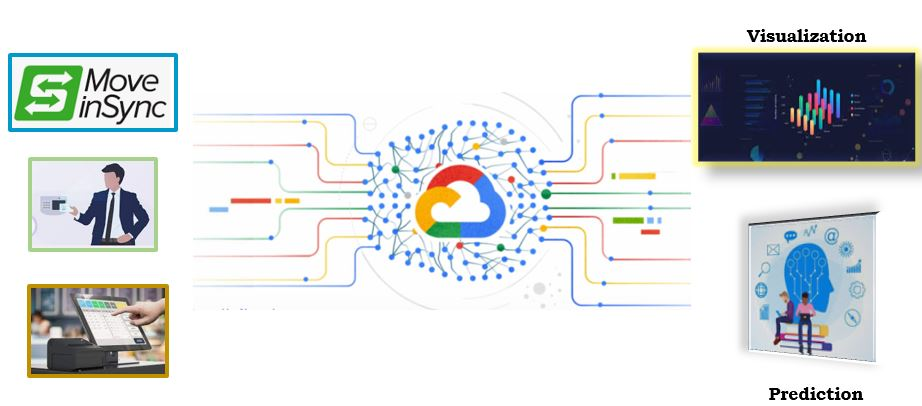

In [2]:
display(Image(filename='input/image1.JPG'))

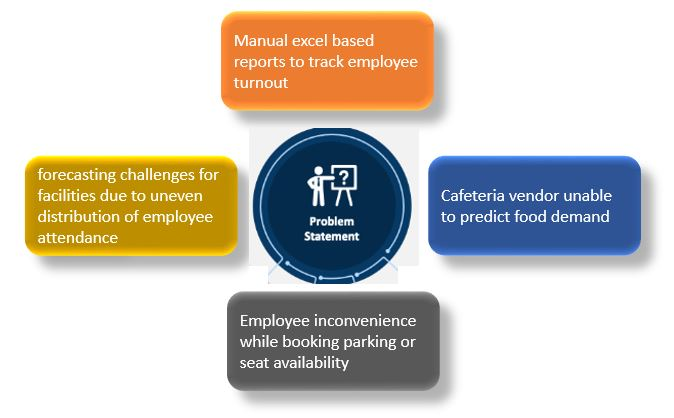

In [3]:
display(Image(filename='input/problem_statement.JPG'))

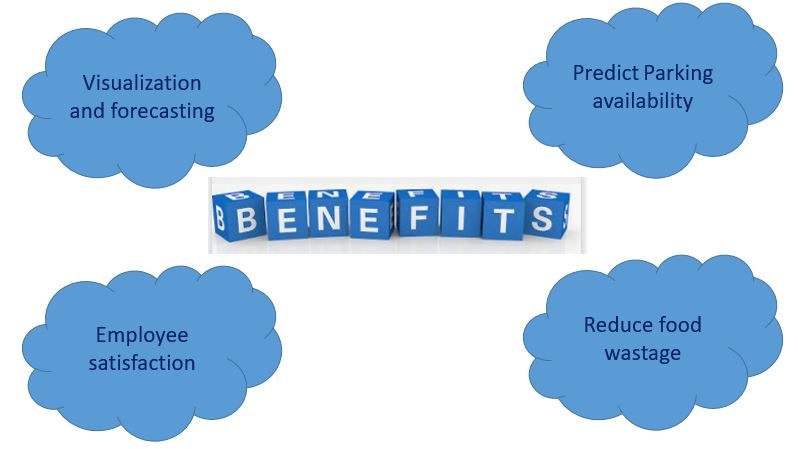

In [4]:
display(Image(filename='input/benefits.JPG'))

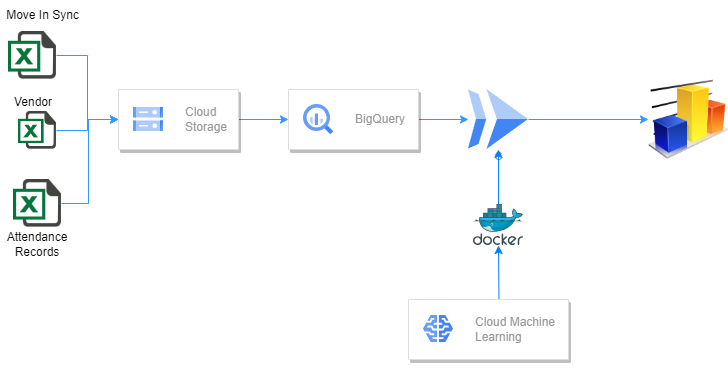

In [5]:
display(Image(filename='input/architecture.png'))

In [6]:
# Import labraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from prophet  import Prophet
import os
import datetime
import numpy as np
import pandas as pd

%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning))

In [7]:
employee_df = pd.read_csv('input/Emp_data_v4.csv')

In [8]:
employee_df.head()

EMP_ID Location          Swipe_In         Swipe_Out  day
0  8626487      MUM  04-10-2022 15:23  05-10-2022 01:23  Tue
1  8631177      MUM  08-06-2023 21:17  09-06-2023 07:17  Thu
2  8678631      MGP  23-12-2022 10:18  23-12-2022 19:18  Fri
3  8574819       BB  03-08-2022 18:26  04-08-2022 05:26  Wed
4  8587539      MGP  12-01-2023 12:57  12-01-2023 18:57  Thu

In [9]:
# Convert to pandas datetime format
employee_df['Swipe_In']=pd.to_datetime(employee_df['Swipe_In'],  format='%d-%m-%Y %H:%M')
employee_df['Swipe_Out']=pd.to_datetime(employee_df['Swipe_Out'],  format='%d-%m-%Y %H:%M')

In [10]:
employee_df['Location'].value_counts()

Location
MGP    405
BB     397
MUM    387
Name: count, dtype: int64

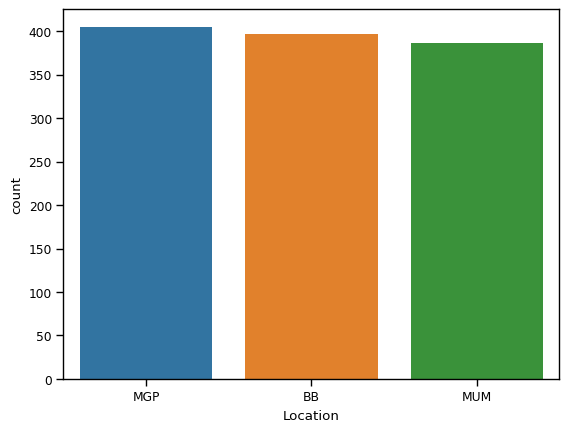

In [11]:
sns.set_context('paper')
sns.barplot(x=employee_df.Location.value_counts().index, y=employee_df.Location.value_counts())
plt.show()

# Comute Dataset 

In [12]:
comute_df = pd.read_csv('input/move_in_sync_data_v3.csv')

In [13]:
comute_df.head()

EMP_ID Location Car_Park  Commute_to_office_mins  Commute_from_office_mins
0  8626487      MGP       NO                    21.0                      32.0
1  8631177      MUM      YES                     NaN                       NaN
2  8678631       BB       NO                    99.0                     200.0
3  8574819      MUM      YES                     NaN                       NaN
4  8587539       BB      YES                     NaN                       NaN

In [14]:
# Can skip MoveinSync data 
#new_df = pd.merge(employee_df, comute_df, on=["EMP_ID","Location"], how="left")
new_df = employee_df

In [15]:
new_df.head()

EMP_ID Location            Swipe_In           Swipe_Out  day
0  8626487      MUM 2022-10-04 15:23:00 2022-10-05 01:23:00  Tue
1  8631177      MUM 2023-06-08 21:17:00 2023-06-09 07:17:00  Thu
2  8678631      MGP 2022-12-23 10:18:00 2022-12-23 19:18:00  Fri
3  8574819       BB 2022-08-03 18:26:00 2022-08-04 05:26:00  Wed
4  8587539      MGP 2023-01-12 12:57:00 2023-01-12 18:57:00  Thu

In [16]:
# Clean data 
new_df = new_df.loc[:, ~new_df.columns.str.contains('^Unnamed')]
new_df.drop(columns=['day'], inplace=True)

In [17]:
new_df['dayofweek'] = new_df['Swipe_In'].dt.dayofweek

In [18]:
new_df.head()

EMP_ID Location            Swipe_In           Swipe_Out  dayofweek
0  8626487      MUM 2022-10-04 15:23:00 2022-10-05 01:23:00          1
1  8631177      MUM 2023-06-08 21:17:00 2023-06-09 07:17:00          3
2  8678631      MGP 2022-12-23 10:18:00 2022-12-23 19:18:00          4
3  8574819       BB 2022-08-03 18:26:00 2022-08-04 05:26:00          2
4  8587539      MGP 2023-01-12 12:57:00 2023-01-12 18:57:00          3

In [19]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1189 entries, 0 to 1188
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   EMP_ID     1189 non-null   int64         
 1   Location   1189 non-null   object        
 2   Swipe_In   1189 non-null   datetime64[ns]
 3   Swipe_Out  1189 non-null   datetime64[ns]
 4   dayofweek  1189 non-null   int32         
dtypes: datetime64[ns](2), int32(1), int64(1), object(1)
memory usage: 41.9+ KB


In [20]:
# Drop most of NA columns
#new_df.drop(columns=['Commute_to_office_mins','Commute_from_office_mins','Car_Park'], inplace=True)

In [21]:
# map the day of the week number to its name
new_df['dayofweek'] = new_df['dayofweek'].map({
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
})

<Axes: >

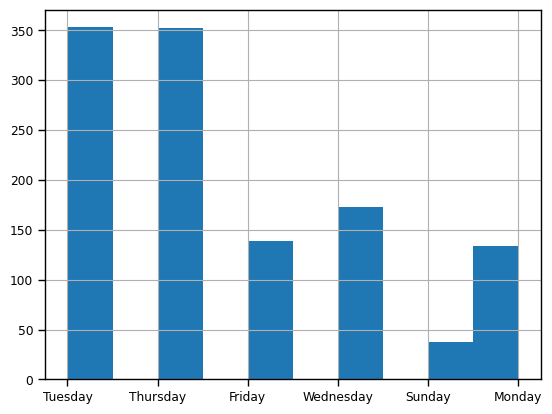

In [22]:
# Distrubution of Employees over the Week
new_df.dayofweek.hist()

In [23]:
new_df.dayofweek.value_counts()  

dayofweek
Tuesday      353
Thursday     352
Wednesday    173
Friday       139
Monday       134
Sunday        38
Name: count, dtype: int64

In [24]:
new_df['Year'] = new_df.Swipe_In.dt.year
new_df['Month'] = new_df.Swipe_In.dt.month
# Considering Swipe_in date as working date
new_df['Working_Date'] = new_df['Swipe_In'].dt.date

In [25]:
new_df.head()

EMP_ID Location            Swipe_In           Swipe_Out  dayofweek  Year  \
0  8626487      MUM 2022-10-04 15:23:00 2022-10-05 01:23:00    Tuesday  2022   
1  8631177      MUM 2023-06-08 21:17:00 2023-06-09 07:17:00   Thursday  2023   
2  8678631      MGP 2022-12-23 10:18:00 2022-12-23 19:18:00     Friday  2022   
3  8574819       BB 2022-08-03 18:26:00 2022-08-04 05:26:00  Wednesday  2022   
4  8587539      MGP 2023-01-12 12:57:00 2023-01-12 18:57:00   Thursday  2023   

   Month Working_Date  
0     10   2022-10-04  
1      6   2023-06-08  
2     12   2022-12-23  
3      8   2022-08-03  
4      1   2023-01-12

In [26]:
num_of_emp_df = new_df['EMP_ID'].groupby([new_df.Working_Date]).agg('count')

In [27]:
Distribution_of_employees= pd.DataFrame(num_of_emp_df)
Distribution_of_employees.rename(columns={'EMP_ID':'Employees','Working_Date':'Year-Month'}, inplace=True)

<Axes: xlabel='Working_Date'>

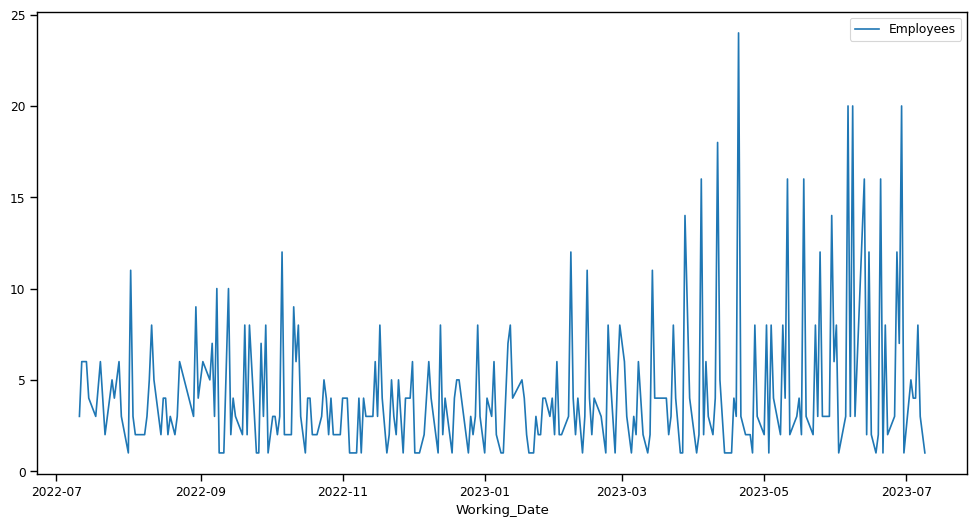

In [28]:
Distribution_of_employees.plot(figsize=(12,6))

# Vendor Dataset

In [29]:
vendor_df = pd.read_csv('input/vendor_v3.csv')

In [30]:
vendor_df.head()

Vendor              Date  Transaction_Value  Unnamed: 3  day
0  ANTARANG  01-09-2022 07:56                289         NaN  Thu
1     SWARA  07-02-2023 04:07                440         NaN  Tue
2    SUBWAY  09-03-2023 07:48                155         NaN  Thu
3     SWARA  29-05-2023 02:57                312         NaN  Mon
4   VOHUMAN  13-03-2023 14:18                459         NaN  Mon

In [31]:
# Convert to pandas datetime format
vendor_df['Date']=pd.to_datetime(vendor_df['Date'],  format='%d-%m-%Y %H:%M')

In [32]:
vendor_df['dayofweek'] = vendor_df['Date'].dt.dayofweek

In [33]:
# map the day of the week number to its name
vendor_df['dayofweek'] = vendor_df['dayofweek'].map({
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
})

In [34]:
vendor_df.head()

Vendor                Date  Transaction_Value  Unnamed: 3  day dayofweek
0  ANTARANG 2022-09-01 07:56:00                289         NaN  Thu  Thursday
1     SWARA 2023-02-07 04:07:00                440         NaN  Tue   Tuesday
2    SUBWAY 2023-03-09 07:48:00                155         NaN  Thu  Thursday
3     SWARA 2023-05-29 02:57:00                312         NaN  Mon    Monday
4   VOHUMAN 2023-03-13 14:18:00                459         NaN  Mon    Monday

In [35]:
vendor_df = vendor_df.loc[:, ~vendor_df.columns.str.contains('^Unnamed')]
vendor_df.drop(columns=['day'], inplace=True)

In [36]:
vendor_df['Transaction_Date'] = vendor_df['Date'].dt.date

In [37]:
num_of_trans_df = vendor_df['Transaction_Value'].groupby([vendor_df.Transaction_Date]).agg('count')

In [38]:
Distribution_of_vender_transactions= pd.DataFrame(num_of_trans_df)
Distribution_of_vender_transactions.rename(columns={'Transaction_Value':'Transactions','Transaction_Date':'Year-Month'}, inplace=True)

<Axes: xlabel='Transaction_Date'>

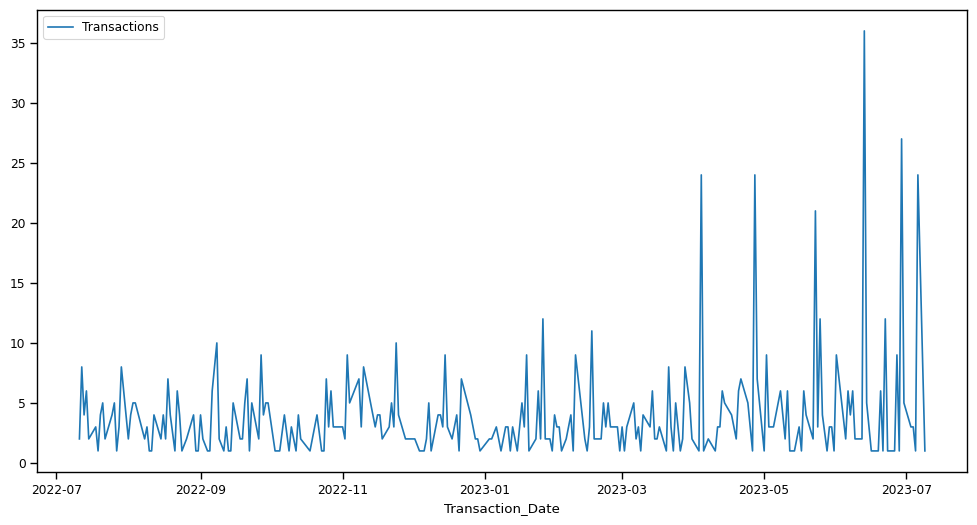

In [39]:
Distribution_of_vender_transactions.plot(figsize=(12,6))

## Forecast Employees and Vendor Transaction Data

##### - Prophet: Automatic Forecasting Procedure on time-series data based
##### - Non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects

In [40]:
dataframe = pd.merge(new_df, vendor_df, left_index=True, right_index=True)

In [41]:
dataframe.head()

EMP_ID Location            Swipe_In           Swipe_Out dayofweek_x  Year  \
0  8626487      MUM 2022-10-04 15:23:00 2022-10-05 01:23:00     Tuesday  2022   
1  8631177      MUM 2023-06-08 21:17:00 2023-06-09 07:17:00    Thursday  2023   
2  8678631      MGP 2022-12-23 10:18:00 2022-12-23 19:18:00      Friday  2022   
3  8574819       BB 2022-08-03 18:26:00 2022-08-04 05:26:00   Wednesday  2022   
4  8587539      MGP 2023-01-12 12:57:00 2023-01-12 18:57:00    Thursday  2023   

   Month Working_Date    Vendor                Date  Transaction_Value  \
0     10   2022-10-04  ANTARANG 2022-09-01 07:56:00                289   
1      6   2023-06-08     SWARA 2023-02-07 04:07:00                440   
2     12   2022-12-23    SUBWAY 2023-03-09 07:48:00                155   
3      8   2022-08-03     SWARA 2023-05-29 02:57:00                312   
4      1   2023-01-12   VOHUMAN 2023-03-13 14:18:00                459   

  dayofweek_y Transaction_Date  
0    Thursday       2022-09-01  
1     Tuesday       2023-02-07  
2    Thursday       2023-03-09  
3      Monday       2023-05-29  
4      Monday       2023-03-13

In [42]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 988 entries, 0 to 987
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   EMP_ID             988 non-null    int64         
 1   Location           988 non-null    object        
 2   Swipe_In           988 non-null    datetime64[ns]
 3   Swipe_Out          988 non-null    datetime64[ns]
 4   dayofweek_x        988 non-null    object        
 5   Year               988 non-null    int32         
 6   Month              988 non-null    int32         
 7   Working_Date       988 non-null    object        
 8   Vendor             988 non-null    object        
 9   Date               988 non-null    datetime64[ns]
 10  Transaction_Value  988 non-null    int64         
 11  dayofweek_y        988 non-null    object        
 12  Transaction_Date   988 non-null    object        
dtypes: datetime64[ns](3), int32(2), int64(2), object(6)
memory usage: 100.

In [43]:
dataframe.drop_duplicates()

EMP_ID Location            Swipe_In           Swipe_Out dayofweek_x  \
0    8626487      MUM 2022-10-04 15:23:00 2022-10-05 01:23:00     Tuesday   
1    8631177      MUM 2023-06-08 21:17:00 2023-06-09 07:17:00    Thursday   
2    8678631      MGP 2022-12-23 10:18:00 2022-12-23 19:18:00      Friday   
3    8574819       BB 2022-08-03 18:26:00 2022-08-04 05:26:00   Wednesday   
4    8587539      MGP 2023-01-12 12:57:00 2023-01-12 18:57:00    Thursday   
..       ...      ...                 ...                 ...         ...   
983  8730472      MGP 2023-01-05 16:56:00 2023-01-06 01:56:00    Thursday   
984  8505236      MGP 2023-04-20 08:05:00 2023-04-20 15:05:00    Thursday   
985  8723459       BB 2023-01-12 17:34:00 2023-01-13 00:34:00    Thursday   
986  8739908      MUM 2023-03-23 12:47:00 2023-03-23 19:47:00    Thursday   
987  8474853       BB 2022-07-14 11:53:00 2022-07-14 17:53:00    Thursday   

     Year  Month Working_Date            Vendor                Date  \
0    2022     10   2022-10-04          ANTARANG 2022-09-01 07:56:00   
1    2023      6   2023-06-08             SWARA 2023-02-07 04:07:00   
2    2022     12   2022-12-23            SUBWAY 2023-03-09 07:48:00   
3    2022      8   2022-08-03             SWARA 2023-05-29 02:57:00   
4    2023      1   2023-01-12           VOHUMAN 2023-03-13 14:18:00   
..    ...    ...          ...               ...                 ...   
983  2023      1   2023-01-05         JUICE BAR 2023-07-06 17:22:00   
984  2023      4   2023-04-20  SOUTHERN EXPRESS 2023-07-06 00:09:00   
985  2023      1   2023-01-12  SOUTHERN EXPRESS 2023-07-06 03:14:00   
986  2023      3   2023-03-23  SOUTHERN EXPRESS 2023-07-06 00:09:00   
987  2022      7   2022-07-14  SOUTHERN EXPRESS 2023-07-06 03:14:00   

     Transaction_Value dayofweek_y Transaction_Date  
0                  289    Thursday       2022-09-01  
1                  440     Tuesday       2023-02-07  
2                  155    Thursday       2023-03-09  
3                  312      Monday       2023-05-29  
4                  459      Monday       2023-03-13  
..                 ...         ...              ...  
983                294    Thursday       2023-07-06  
984                422    Thursday       2023-07-06  
985                337    Thursday       2023-07-06  
986                422    Thursday       2023-07-06  
987                337    Thursday       2023-07-06  

[988 rows x 13 columns]

In [44]:
dataframe.drop(columns=['dayofweek_y'], inplace=True)

In [45]:
dataframe.Vendor.unique().tolist()

['ANTARANG',
 'SWARA',
 'SUBWAY',
 'VOHUMAN',
 'WOK',
 'BISTRO',
 'SOUTHERN EXPRESS',
 'JUICE BAR']

In [46]:
import plotly.express as px

In [47]:
dataframe.Vendor.value_counts()
# dataframe.groupby('Vendor').Vendor.count()

Vendor
ANTARANG            205
SOUTHERN EXPRESS    158
SWARA               133
WOK                 114
SUBWAY               98
JUICE BAR            97
VOHUMAN              94
BISTRO               89
Name: count, dtype: int64

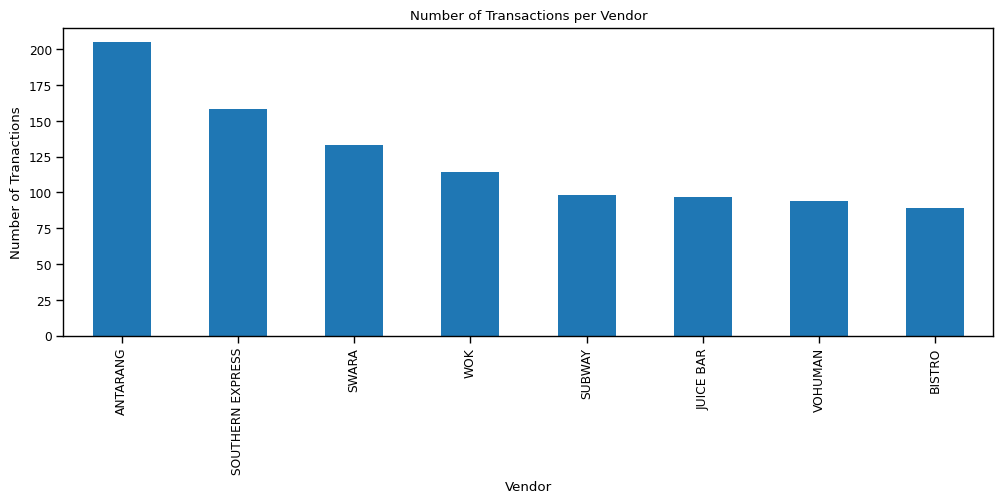

In [48]:
dataframe.Vendor.value_counts().plot(kind='bar',figsize=(12,4)) 
plt.xlabel('Vendor');
plt.ylabel('Number of Tranactions');
plt.title('Number of Transactions per Vendor');

In [49]:
dataframe.groupby('Vendor').Transaction_Value.mean()

Vendor
ANTARANG            245.575610
BISTRO              284.741573
JUICE BAR           240.288660
SOUTHERN EXPRESS    291.487342
SUBWAY              260.285714
SWARA               273.052632
VOHUMAN             266.691489
WOK                 257.833333
Name: Transaction_Value, dtype: float64

<Axes: >

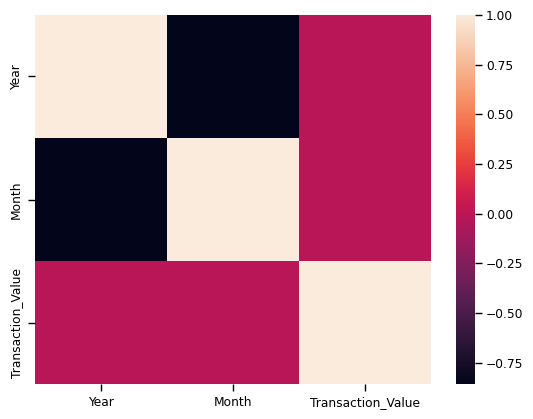

In [50]:
sns.heatmap(dataframe[['Year','Month','Transaction_Value']].corr())

C:\Users\rahul\anaconda3\envs\hackathon\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


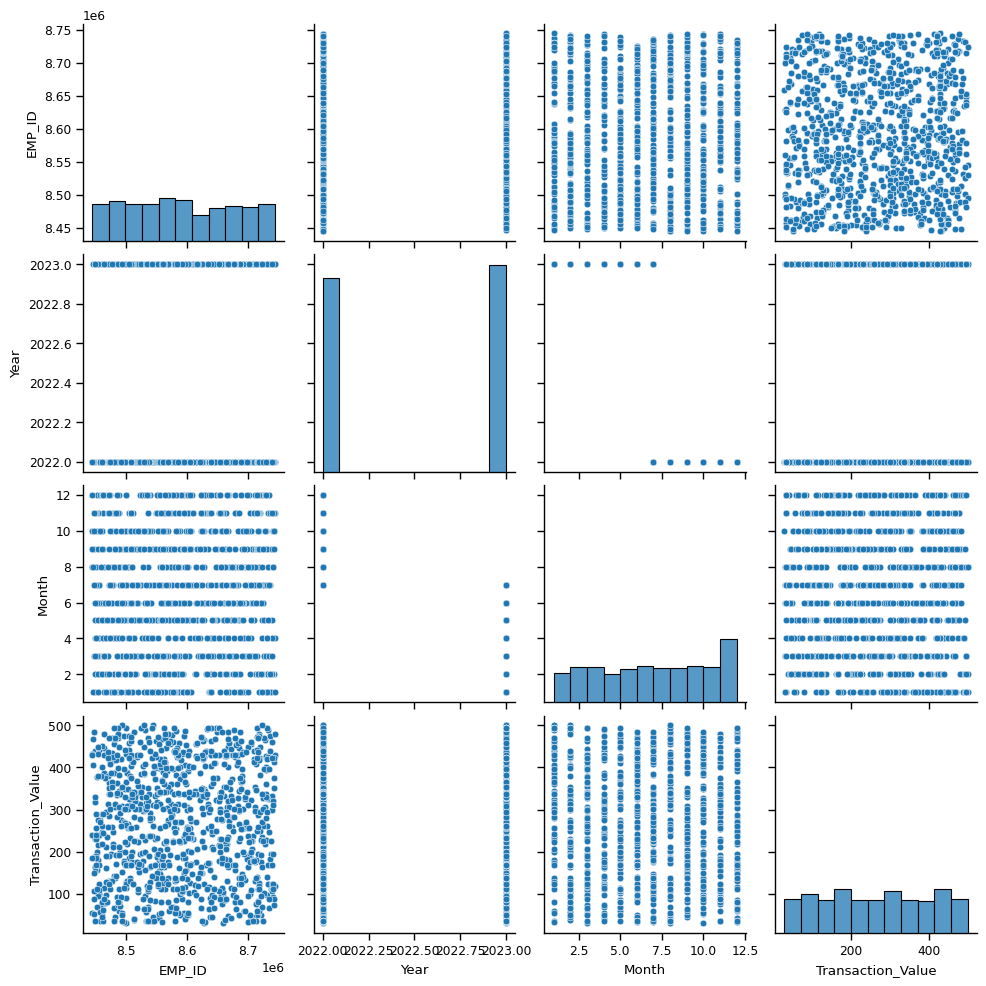

In [51]:
sns.pairplot(dataframe)

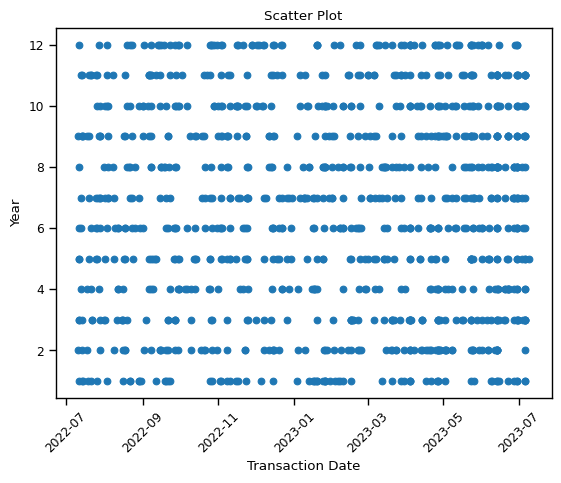

In [52]:
plt.scatter(dataframe['Transaction_Date'], dataframe['Month'])

# Set labels and title
plt.xlabel('Transaction Date')
plt.ylabel('Year')
plt.title('Scatter Plot')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [53]:
raw_df = dataframe[['Working_Date','Transaction_Value','Vendor','dayofweek_x','Month','Year','Location']]

In [54]:
raw_df['Working_Date'] = pd.to_datetime(raw_df['Working_Date'])

C:\Users\rahul\AppData\Local\Temp\ipykernel_15112\2862114500.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_df['Working_Date'] = pd.to_datetime(raw_df['Working_Date'])


In [55]:
raw_df[(raw_df.Vendor == "ANTARANG") & (raw_df.Year == 2022) ]

Working_Date  Transaction_Value    Vendor dayofweek_x  Month  Year  \
0     2022-10-04                289  ANTARANG     Tuesday     10  2022   
50    2022-10-12                296  ANTARANG   Wednesday     10  2022   
61    2022-11-20                404  ANTARANG      Sunday     11  2022   
67    2022-11-14                449  ANTARANG      Monday     11  2022   
84    2022-09-22                484  ANTARANG    Thursday      9  2022   
..           ...                ...       ...         ...    ...   ...   
942   2022-08-18                123  ANTARANG    Thursday      8  2022   
947   2022-07-28                137  ANTARANG    Thursday      7  2022   
953   2022-08-11                 35  ANTARANG    Thursday      8  2022   
971   2022-08-04                 35  ANTARANG    Thursday      8  2022   
973   2022-11-17                123  ANTARANG    Thursday     11  2022   

    Location  
0        MUM  
50       MGP  
61        BB  
67       MUM  
84        BB  
..       ...  
942      MGP  
947      MUM  
953       BB  
971       BB  
973      MUM  

[110 rows x 7 columns]

In [56]:
raw_df.set_index('Working_Date')

Transaction_Value            Vendor dayofweek_x  Month  Year  \
Working_Date                                                                 
2022-10-04                  289          ANTARANG     Tuesday     10  2022   
2023-06-08                  440             SWARA    Thursday      6  2023   
2022-12-23                  155            SUBWAY      Friday     12  2022   
2022-08-03                  312             SWARA   Wednesday      8  2022   
2023-01-12                  459           VOHUMAN    Thursday      1  2023   
...                         ...               ...         ...    ...   ...   
2023-01-05                  294         JUICE BAR    Thursday      1  2023   
2023-04-20                  422  SOUTHERN EXPRESS    Thursday      4  2023   
2023-01-12                  337  SOUTHERN EXPRESS    Thursday      1  2023   
2023-03-23                  422  SOUTHERN EXPRESS    Thursday      3  2023   
2022-07-14                  337  SOUTHERN EXPRESS    Thursday      7  2022   

             Location  
Working_Date           
2022-10-04        MUM  
2023-06-08        MUM  
2022-12-23        MGP  
2022-08-03         BB  
2023-01-12        MGP  
...               ...  
2023-01-05        MGP  
2023-04-20        MGP  
2023-01-12         BB  
2023-03-23        MUM  
2022-07-14         BB  

[988 rows x 6 columns]

<Axes: xlabel='Working_Date'>

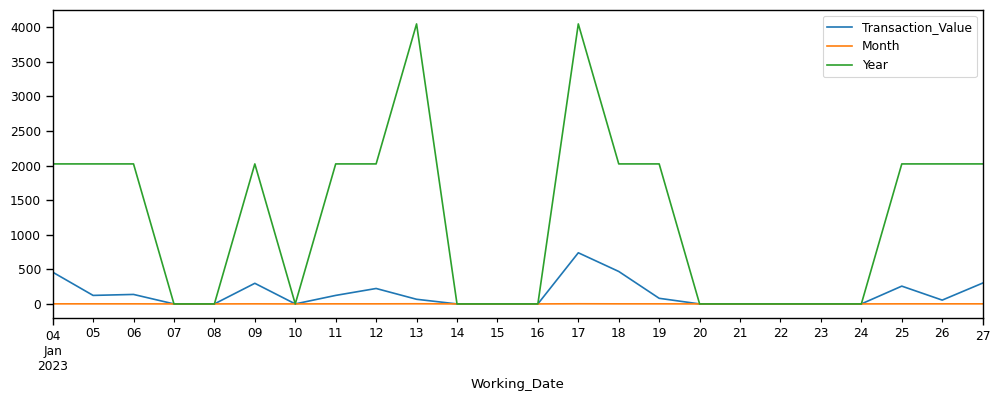

In [57]:
raw_df[(raw_df.Vendor == "ANTARANG") & (raw_df.Month == 1) ].set_index('Working_Date').resample('D').sum().plot(kind='line',figsize=(12,4))

<Axes: xlabel='Working_Date'>

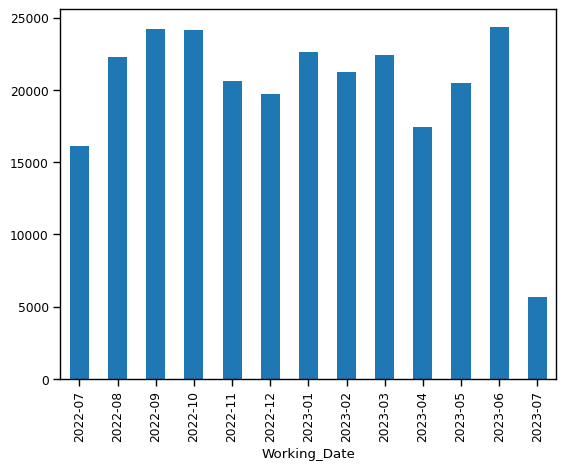

In [58]:
raw_df['Transaction_Value'].groupby(raw_df['Working_Date'].dt.to_period('M')).sum().plot(kind='bar')

In [59]:
dataframe.head()

EMP_ID Location            Swipe_In           Swipe_Out dayofweek_x  Year  \
0  8626487      MUM 2022-10-04 15:23:00 2022-10-05 01:23:00     Tuesday  2022   
1  8631177      MUM 2023-06-08 21:17:00 2023-06-09 07:17:00    Thursday  2023   
2  8678631      MGP 2022-12-23 10:18:00 2022-12-23 19:18:00      Friday  2022   
3  8574819       BB 2022-08-03 18:26:00 2022-08-04 05:26:00   Wednesday  2022   
4  8587539      MGP 2023-01-12 12:57:00 2023-01-12 18:57:00    Thursday  2023   

   Month Working_Date    Vendor                Date  Transaction_Value  \
0     10   2022-10-04  ANTARANG 2022-09-01 07:56:00                289   
1      6   2023-06-08     SWARA 2023-02-07 04:07:00                440   
2     12   2022-12-23    SUBWAY 2023-03-09 07:48:00                155   
3      8   2022-08-03     SWARA 2023-05-29 02:57:00                312   
4      1   2023-01-12   VOHUMAN 2023-03-13 14:18:00                459   

  Transaction_Date  
0       2022-09-01  
1       2023-02-07  
2       2023-03-09  
3       2023-05-29  
4       2023-03-13

In [60]:
df = dataframe['Transaction_Value'].groupby(dataframe['Date'].dt.to_period('D')).sum().to_frame()

In [61]:
df.Working_Date = df.to_timestamp()

C:\Users\rahul\AppData\Local\Temp\ipykernel_15112\295913564.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.Working_Date = df.to_timestamp()


In [62]:
df.reset_index(level=0, inplace=True)

In [63]:
df.rename(columns={'Date':'ds','Transaction_Value':'y'}, inplace=True)

In [64]:
df.head()

ds     y
0  2022-07-11   692
1  2022-07-12  1746
2  2022-07-13  1134
3  2022-07-14  2154
4  2022-07-15   630

In [65]:
df['ds'] = df['ds'].dt.to_timestamp('s').dt.strftime('%Y-%m-%d %H:%M:%S.000')

In [66]:
df.head()

ds     y
0  2022-07-11 00:00:00.000   692
1  2022-07-12 00:00:00.000  1746
2  2022-07-13 00:00:00.000  1134
3  2022-07-14 00:00:00.000  2154
4  2022-07-15 00:00:00.000   630

In [67]:
model = Prophet()
model.fit(df)

12:03:48 - cmdstanpy - INFO - Chain [1] start processing
12:03:48 - cmdstanpy - INFO - Chain [1] done processing


In [68]:
future_dates = model.make_future_dataframe(periods=30)

In [69]:
forecast = model.predict(future_dates)

In [70]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


ds         yhat  yhat_lower   yhat_upper
275 2023-08-04  1233.778547  -64.475120  2490.447688
276 2023-08-05  1373.644788  150.665895  2601.188426
277 2023-08-06   721.026653 -674.231198  1970.800090
278 2023-08-07  1118.305821 -151.003614  2428.115108
279 2023-08-08  1882.152941  613.373099  3266.782140

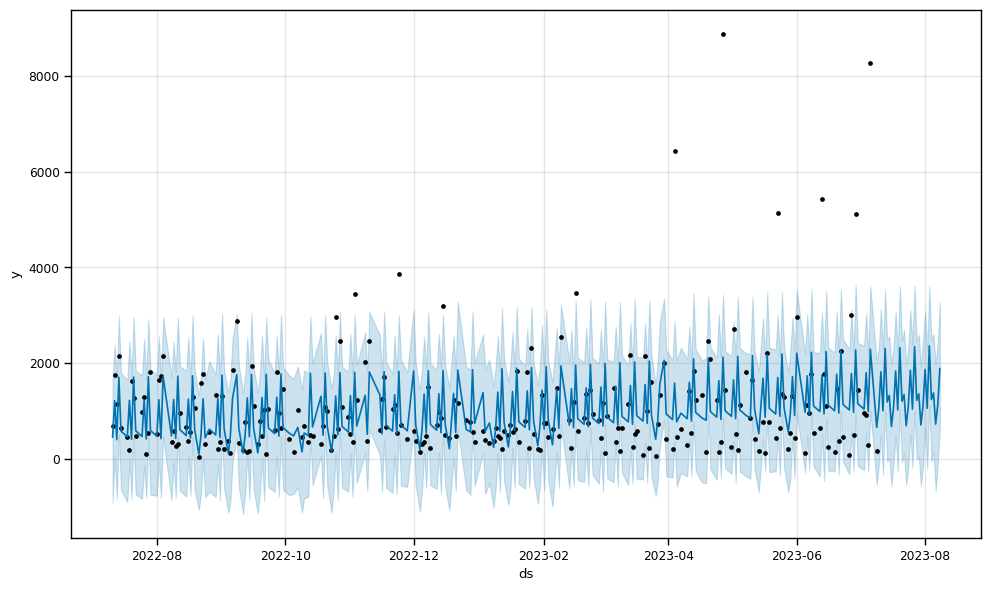

In [71]:
# Forecast data for 30 days 
fig1 = model.plot(forecast)


In [72]:
# Prediction for 365 days 
future = model.make_future_dataframe(periods=365)
future.tail()

ds
610 2024-07-04
611 2024-07-05
612 2024-07-06
613 2024-07-07
614 2024-07-08

In [73]:
forecast.head()

ds       trend  yhat_lower   yhat_upper  trend_lower  trend_upper  \
0 2022-07-11  726.244783 -919.494374  1747.723899   726.244783   726.244783   
1 2022-07-12  727.193217   36.625034  2366.528149   727.193217   727.193217   
2 2022-07-13  728.141652 -858.213238  1689.918177   728.141652   728.141652   
3 2022-07-14  729.090087  500.221884  2980.304128   729.090087   729.090087   
4 2022-07-15  730.038522 -660.903710  1797.272601   730.038522   730.038522   

   additive_terms  additive_terms_lower  additive_terms_upper      weekly  \
0     -277.463162           -277.463162           -277.463162 -277.463162   
1      483.997350            483.997350            483.997350  483.997350   
2     -332.176757           -332.176757           -332.176757 -332.176757   
3      970.179878            970.179878            970.179878  970.179878   
4     -154.830610           -154.830610           -154.830610 -154.830610   

   weekly_lower  weekly_upper  multiplicative_terms  \
0   -277.463162   -277.463162                   0.0   
1    483.997350    483.997350                   0.0   
2   -332.176757   -332.176757                   0.0   
3    970.179878    970.179878                   0.0   
4   -154.830610   -154.830610                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper         yhat  
0                         0.0                         0.0   448.781621  
1                         0.0                         0.0  1211.190567  
2                         0.0                         0.0   395.964895  
3                         0.0                         0.0  1699.269965  
4                         0.0                         0.0   575.207912

In [74]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds         yhat   yhat_lower   yhat_upper
610 2024-07-04  3158.302933  1971.624861  4428.910797
611 2024-07-05  2035.679054   709.211703  3375.576163
612 2024-07-06  2175.545295   896.426809  3465.597596
613 2024-07-07  1522.927160   307.145372  2789.673437
614 2024-07-08  1920.206328   758.109418  3185.938132

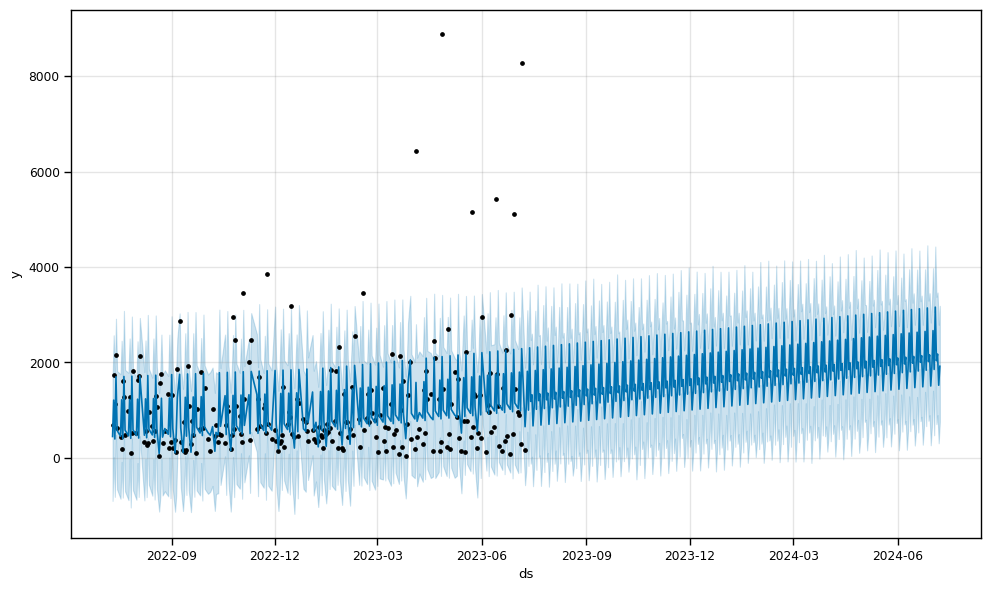

In [75]:
# Forecast for 365 Days
fig1 = model.plot(forecast)

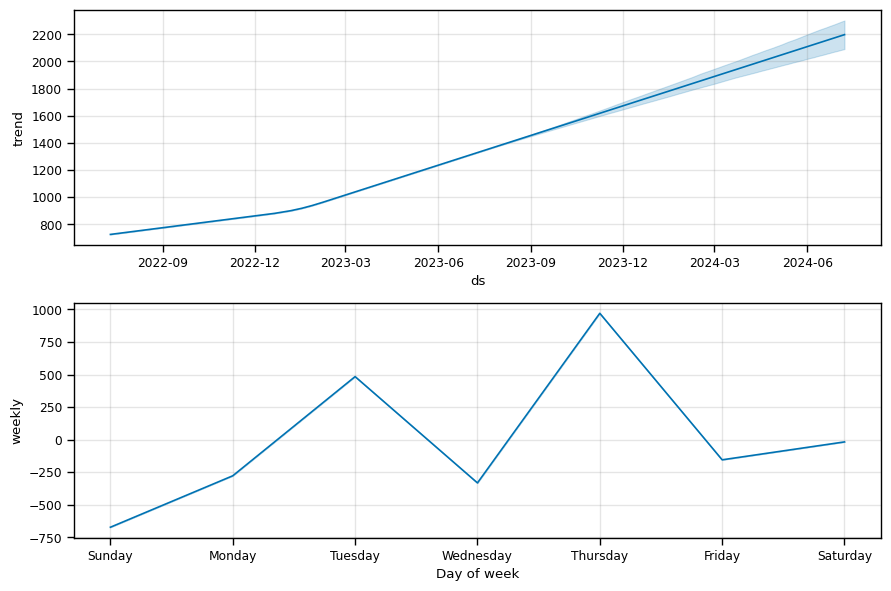

In [76]:
fig2 = model.plot_components(forecast)

In [77]:
from prophet.plot import plot_plotly, plot_components_plotly

In [78]:
# Interactive plot for 365 days
plot_plotly(model, forecast)

In [79]:
plot_components_plotly(model, forecast)

In [80]:
from prophet.serialize import model_to_json, model_from_json

with open('prophet_model.json', 'w') as fout:
    fout.write(model_to_json(model))  # Save model

In [81]:
raw_df.head()

Working_Date  Transaction_Value    Vendor dayofweek_x  Month  Year Location
0   2022-10-04                289  ANTARANG     Tuesday     10  2022      MUM
1   2023-06-08                440     SWARA    Thursday      6  2023      MUM
2   2022-12-23                155    SUBWAY      Friday     12  2022      MGP
3   2022-08-03                312     SWARA   Wednesday      8  2022       BB
4   2023-01-12                459   VOHUMAN    Thursday      1  2023      MGP

In [82]:
forecast.head()

ds       trend  yhat_lower   yhat_upper  trend_lower  trend_upper  \
0 2022-07-11  726.244783 -900.491002  1662.855235   726.244783   726.244783   
1 2022-07-12  727.193217   14.208236  2569.637722   727.193217   727.193217   
2 2022-07-13  728.141652 -816.329183  1682.860796   728.141652   728.141652   
3 2022-07-14  729.090087  480.696101  2916.468654   729.090087   729.090087   
4 2022-07-15  730.038522 -661.012547  1818.269543   730.038522   730.038522   

   additive_terms  additive_terms_lower  additive_terms_upper      weekly  \
0     -277.463162           -277.463162           -277.463162 -277.463162   
1      483.997350            483.997350            483.997350  483.997350   
2     -332.176757           -332.176757           -332.176757 -332.176757   
3      970.179878            970.179878            970.179878  970.179878   
4     -154.830610           -154.830610           -154.830610 -154.830610   

   weekly_lower  weekly_upper  multiplicative_terms  \
0   -277.463162   -277.463162                   0.0   
1    483.997350    483.997350                   0.0   
2   -332.176757   -332.176757                   0.0   
3    970.179878    970.179878                   0.0   
4   -154.830610   -154.830610                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper         yhat  
0                         0.0                         0.0   448.781621  
1                         0.0                         0.0  1211.190567  
2                         0.0                         0.0   395.964895  
3                         0.0                         0.0  1699.269965  
4                         0.0                         0.0   575.207912

In [83]:
num_of_emp_df.head()


Working_Date
2022-07-11    3
2022-07-12    6
2022-07-13    6
2022-07-14    6
2022-07-15    4
Name: EMP_ID, dtype: int64

## Seasonality, Holiday Effects, And Regressors

In [84]:
model = Prophet()
model.add_country_holidays(country_name='IN')
model.fit(df)

C:\Users\rahul\anaconda3\envs\hackathon\Lib\site-packages\holidays\countries\india.py:101: Warning:

Diwali and Holi holidays available from 2001 to 2030 only

12:03:54 - cmdstanpy - INFO - Chain [1] start processing
12:03:54 - cmdstanpy - INFO - Chain [1] done processing


In [85]:
forecast = model.predict(future)


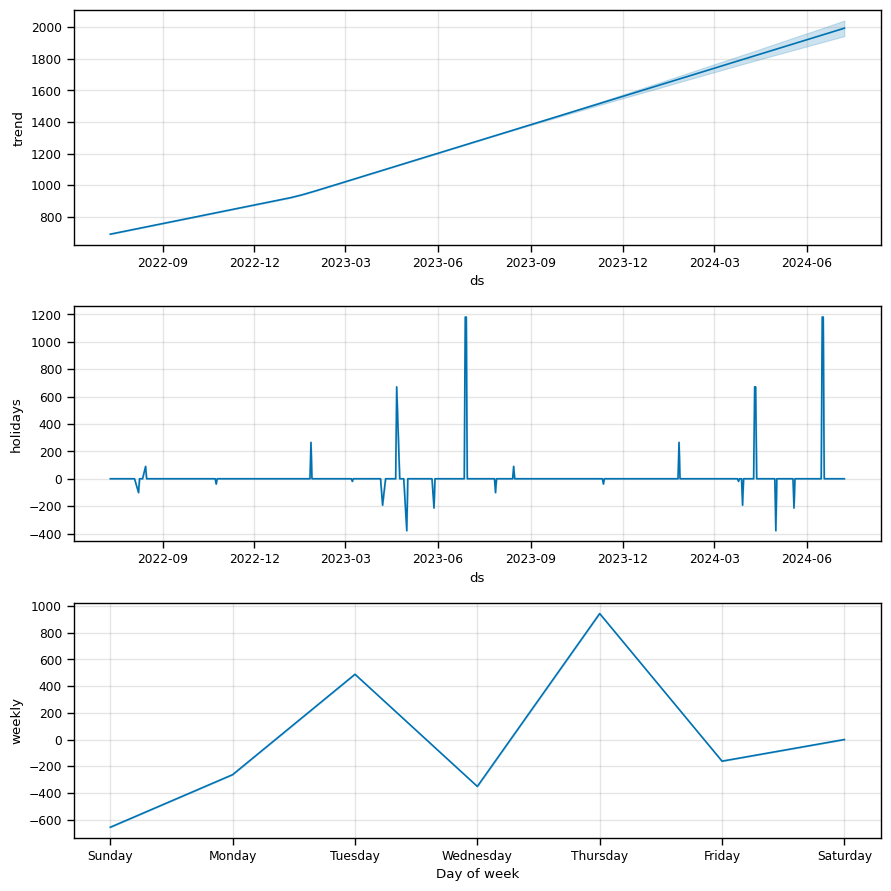

In [86]:
fig = model.plot_components(forecast)

# Thank You 🎈